# Scipy gaussian spot size fits for Noshin

In [1]:
## Import dependencies
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs
from scipy.optimize import curve_fit

In [2]:
## [CHANGE THIS ON YOUR COMPUTER!] 
## First specify where you are storing the .tif images
## The file that you sent to me is currently in my downloads folder:
filepath = "C:\\Users\\Hannah\\Downloads\\"
os.chdir(filepath)

## Next specify the name of the file that you want to analyze
## Do not include the ``.tif`` part of the filename
filename = "3"

# Pull measurement from .tif file 
To do this, we will modify functions from the existing ``lasebeamsize`` package: https://pypi.org/project/laserbeamsize/


In [3]:
def get_spot_size(imagename, pixel_size=4.8):
    beam = imageio.imread(imagename + ".tif")


    x, y, dx, dy, phi = lbs.beam_size(beam, iso_noise=False) #, max_iter=1) #, iso_noise=False)

    print("The center of the beam ellipse is at (%.0f, %.0f)" % (x,y))
    print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
    print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
    print("The ellipse is rotated %.0f° ccw from horizontal" % (phi*180/3.1416))

    #lbs.beam_size_plot(beam, f"Original Image, {imagename}.tif", pixel_size = 5.86, units='µm')
    
    semimajor_x, semimajor_y, semiminor_x, semiminor_y = plot_image_analysis(beam, f"Original Image, {imagename}.tif", 
                                                                             pixel_size=pixel_size, units='µm', iso_noise=False)
    plt.show()
    return semimajor_x, semimajor_y, semiminor_x, semiminor_y

def plot_image_analysis(o_image,
                        title='Original',
                        pixel_size=None,
                        units='µm',
                        crop=False,
                        cmap='gist_ncar',
                        corner_fraction=0.035,
                        nT=3,
                        iso_noise=True,
                        **kwargs):
    """
    Create a visual report for image fitting.

    If `crop` is a two parameter list `[v, h]` then `v` and `h` are
    interpreted as the vertical and horizontal sizes of the rectangle.  The
    size is in pixels unless `pixel_size` is specified.  In that case the
    rectangle sizes are in whatever units `pixel_size` is .

    If `crop==True` then the displayed image is cropped to the ISO 11146 integration
    rectangle.

    All cropping is done after analysis and therefosre only affects
    what is displayed.  If the image needs to be cropped before analysis
    then that must be done before calling this function.

    Args:
        o_image: 2D image of laser beam
        title: (optional) title for upper left plot
        pixel_size: (optional) size of pixels
        units: (optional) string used for units used on axes
        crop: (optional) crop image to integration rectangle
        cmap: (optional) colormap to use
    Returns:
        nothing
    """
    # only pass along arguments that apply to beam_size()
    bs_args = dict((k, kwargs[k]) for k in ['mask_diameters', 'max_iter', 'phi'] if k in kwargs)
    bs_args['iso_noise'] = iso_noise
    bs_args['nT'] = nT
    bs_args['corner_fraction'] = corner_fraction

    # find center and diameters
    xc, yc, dx, dy, phi = lbs.beam_size(o_image, **bs_args)

    # determine scaling and labels
    if pixel_size is None:
        scale = 1
        unit_str = ''
        units = 'pixels'
        label = 'Pixels from Center'
    else:
        scale = pixel_size
        unit_str = '[%s]' % units
        label = 'Distance from Center %s' % unit_str

    # crop image as appropriate
    if isinstance(crop, list):
        ymin = yc - crop[0] / 2 / scale  # in pixels
        ymax = yc + crop[0] / 2 / scale
        xmin = xc - crop[1] / 2 / scale
        xmax = xc + crop[1] / 2 / scale
        image, xc, yc = lbs.crop_image_to_rect(o_image, xc, yc, xmin, xmax, ymin, ymax)
    elif crop:
        image, xc, yc = lbs.crop_image_to_integration_rect(o_image, xc, yc, dx, dy, phi)
    else:
        image = o_image

    # subtract background
    working_image = lbs.subtract_iso_background(image, corner_fraction=corner_fraction,
                                                nT=nT, iso_noise=iso_noise)
    bkgnd, _ = lbs.iso_background(image, corner_fraction=corner_fraction, nT=nT)

    min_ = image.min()
    max_ = image.max()
    vv, hh = image.shape

    # determine the sizes of the semi-major and semi-minor axes
    r_major = max(dx, dy) / 2.0
    r_minor = min(dx, dy) / 2.0

    # scale all the dimensions
    v_s = vv * scale
    h_s = hh * scale
    xc_s = xc * scale
    yc_s = yc * scale
    r_mag_s = r_major * scale
    d_mag_s = r_mag_s * 2
    r_min_s = r_minor * scale
    d_min_s = r_min_s * 2

    # original image

    # working image
    extent = np.array([-xc_s, h_s - xc_s, v_s - yc_s, -yc_s])
    xp, yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi) * scale
    #lbs.plot_visible_dotted_line(xp - xc_s, yp - yc_s)

    xp, yp = lbs.axes_arrays(xc, yc, dx, dy, phi) * scale
    #plot_visible_dotted_line(xp - xc_s, yp - yc_s)

    xp, yp = lbs.rotated_rect_arrays(xc, yc, dx, dy, phi) * scale
    #plot_visible_dotted_line(xp - xc_s, yp - yc_s)
    # plot of values along semi-major axis
    _, _, z, s = lbs.major_axis_arrays(image, xc, yc, dx, dy, phi)
    a = np.sqrt(2 / np.pi) / r_major * abs(np.sum(z - bkgnd) * (s[1] - s[0]))
    baseline = a * np.exp(-2) + bkgnd
    semimajor_x = s * scale
    semimajor_y = z
    # plt.gca().set_ylim(bottom=0)

    # plot of values along semi-minor axis
    _, _, z, s = lbs.minor_axis_arrays(image, xc, yc, dx, dy, phi)
    a = np.sqrt(2 / np.pi) / r_minor * abs(np.sum(z - bkgnd) * (s[1] - s[0]))
    baseline = a * np.exp(-2) + bkgnd

    semiminor_x = s * scale
    semiminor_y = z
    z_values = bkgnd + a * np.exp(-2 * (s / r_minor)**2)
    # plt.gca().set_ylim(bottom=0)

    # add more horizontal space between plots
    return semimajor_x, semimajor_y, semiminor_x, semiminor_y

## Now pull semimajor and semiminor axes values from the file

In [4]:
semimajor_x, semimajor_y, semiminor_x, semiminor_y = get_spot_size(filename)

C:\Users\Hannah\AppData\Local\Temp\ipykernel_43200\2701054625.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  beam = imageio.imread(imagename + ".tif")


The center of the beam ellipse is at (1325, 129)
The ellipse diameter (closest to horizontal) is 31 pixels
The ellipse diameter (closest to   vertical) is 37 pixels
The ellipse is rotated 33° ccw from horizontal


# Now we want to define our own fits using scipy

In [5]:
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

## Write a function to fit to the gaussian distrbution
def fit_gaussian(x_data, y_data, savepath="./", title="Gaussian Fit"):
    ## Initial guess for parameters: mu, sigma, A
    initial_guess = [0, 1, 1]

    ## Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)

    ## Extract fitted parameters
    mu_fit, sigma_fit, A_fit = popt

    ## Calculate FWHM from sigma
    fwhm = 2.355 * sigma_fit
    arrow_start = mu_fit - 2 * sigma_fit
    arrow_end = mu_fit + 2 * sigma_fit

    ## Plot data and fitted curve
    plt.figure(figsize=(8,6))
    plt.plot(x_data[10:-10], y_data[10:-10], "o", color="black", label='Measured')
    plt.plot(x_data[10:-10], gaussian(x_data, *popt)[10:-10], linewidth=2, color="cornflowerblue", label='Gaussian Fit')
    plt.plot(x_data[10:-10], y_data[10:-10], "o", color="black")
    plt.annotate('', xy=(arrow_start, gaussian(arrow_start, *popt)), xytext=(arrow_end, gaussian(arrow_end, *popt)),
                arrowprops=dict(arrowstyle='<->', color='crimson', linewidth=2,))
    plt.text(0, 80, '±2σ =%.0f %s' % (4 * sigma_fit, "μm"), va='bottom', ha='center', color="crimson")
    plt.xlabel('Position [μm]')
    plt.ylabel('Pixel Intensity')
    plt.title(title)
    plt.legend()
    plt.savefig((savepath+'semiminor.png'), bbox_inches='tight')
    plt.show()

    print("FWHM of the Gaussian: {:.2f}".format(fwhm))

# And finally fit the data to the scipy functions

In [6]:
params = {
    'font.size': 21,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.0,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 20,
    'figure.dpi': 400,
    'savefig.dpi': 400,
    'savefig.format': 'pdf',  # or 'eps', 'svg'
}
plt.rcParams.update(params)

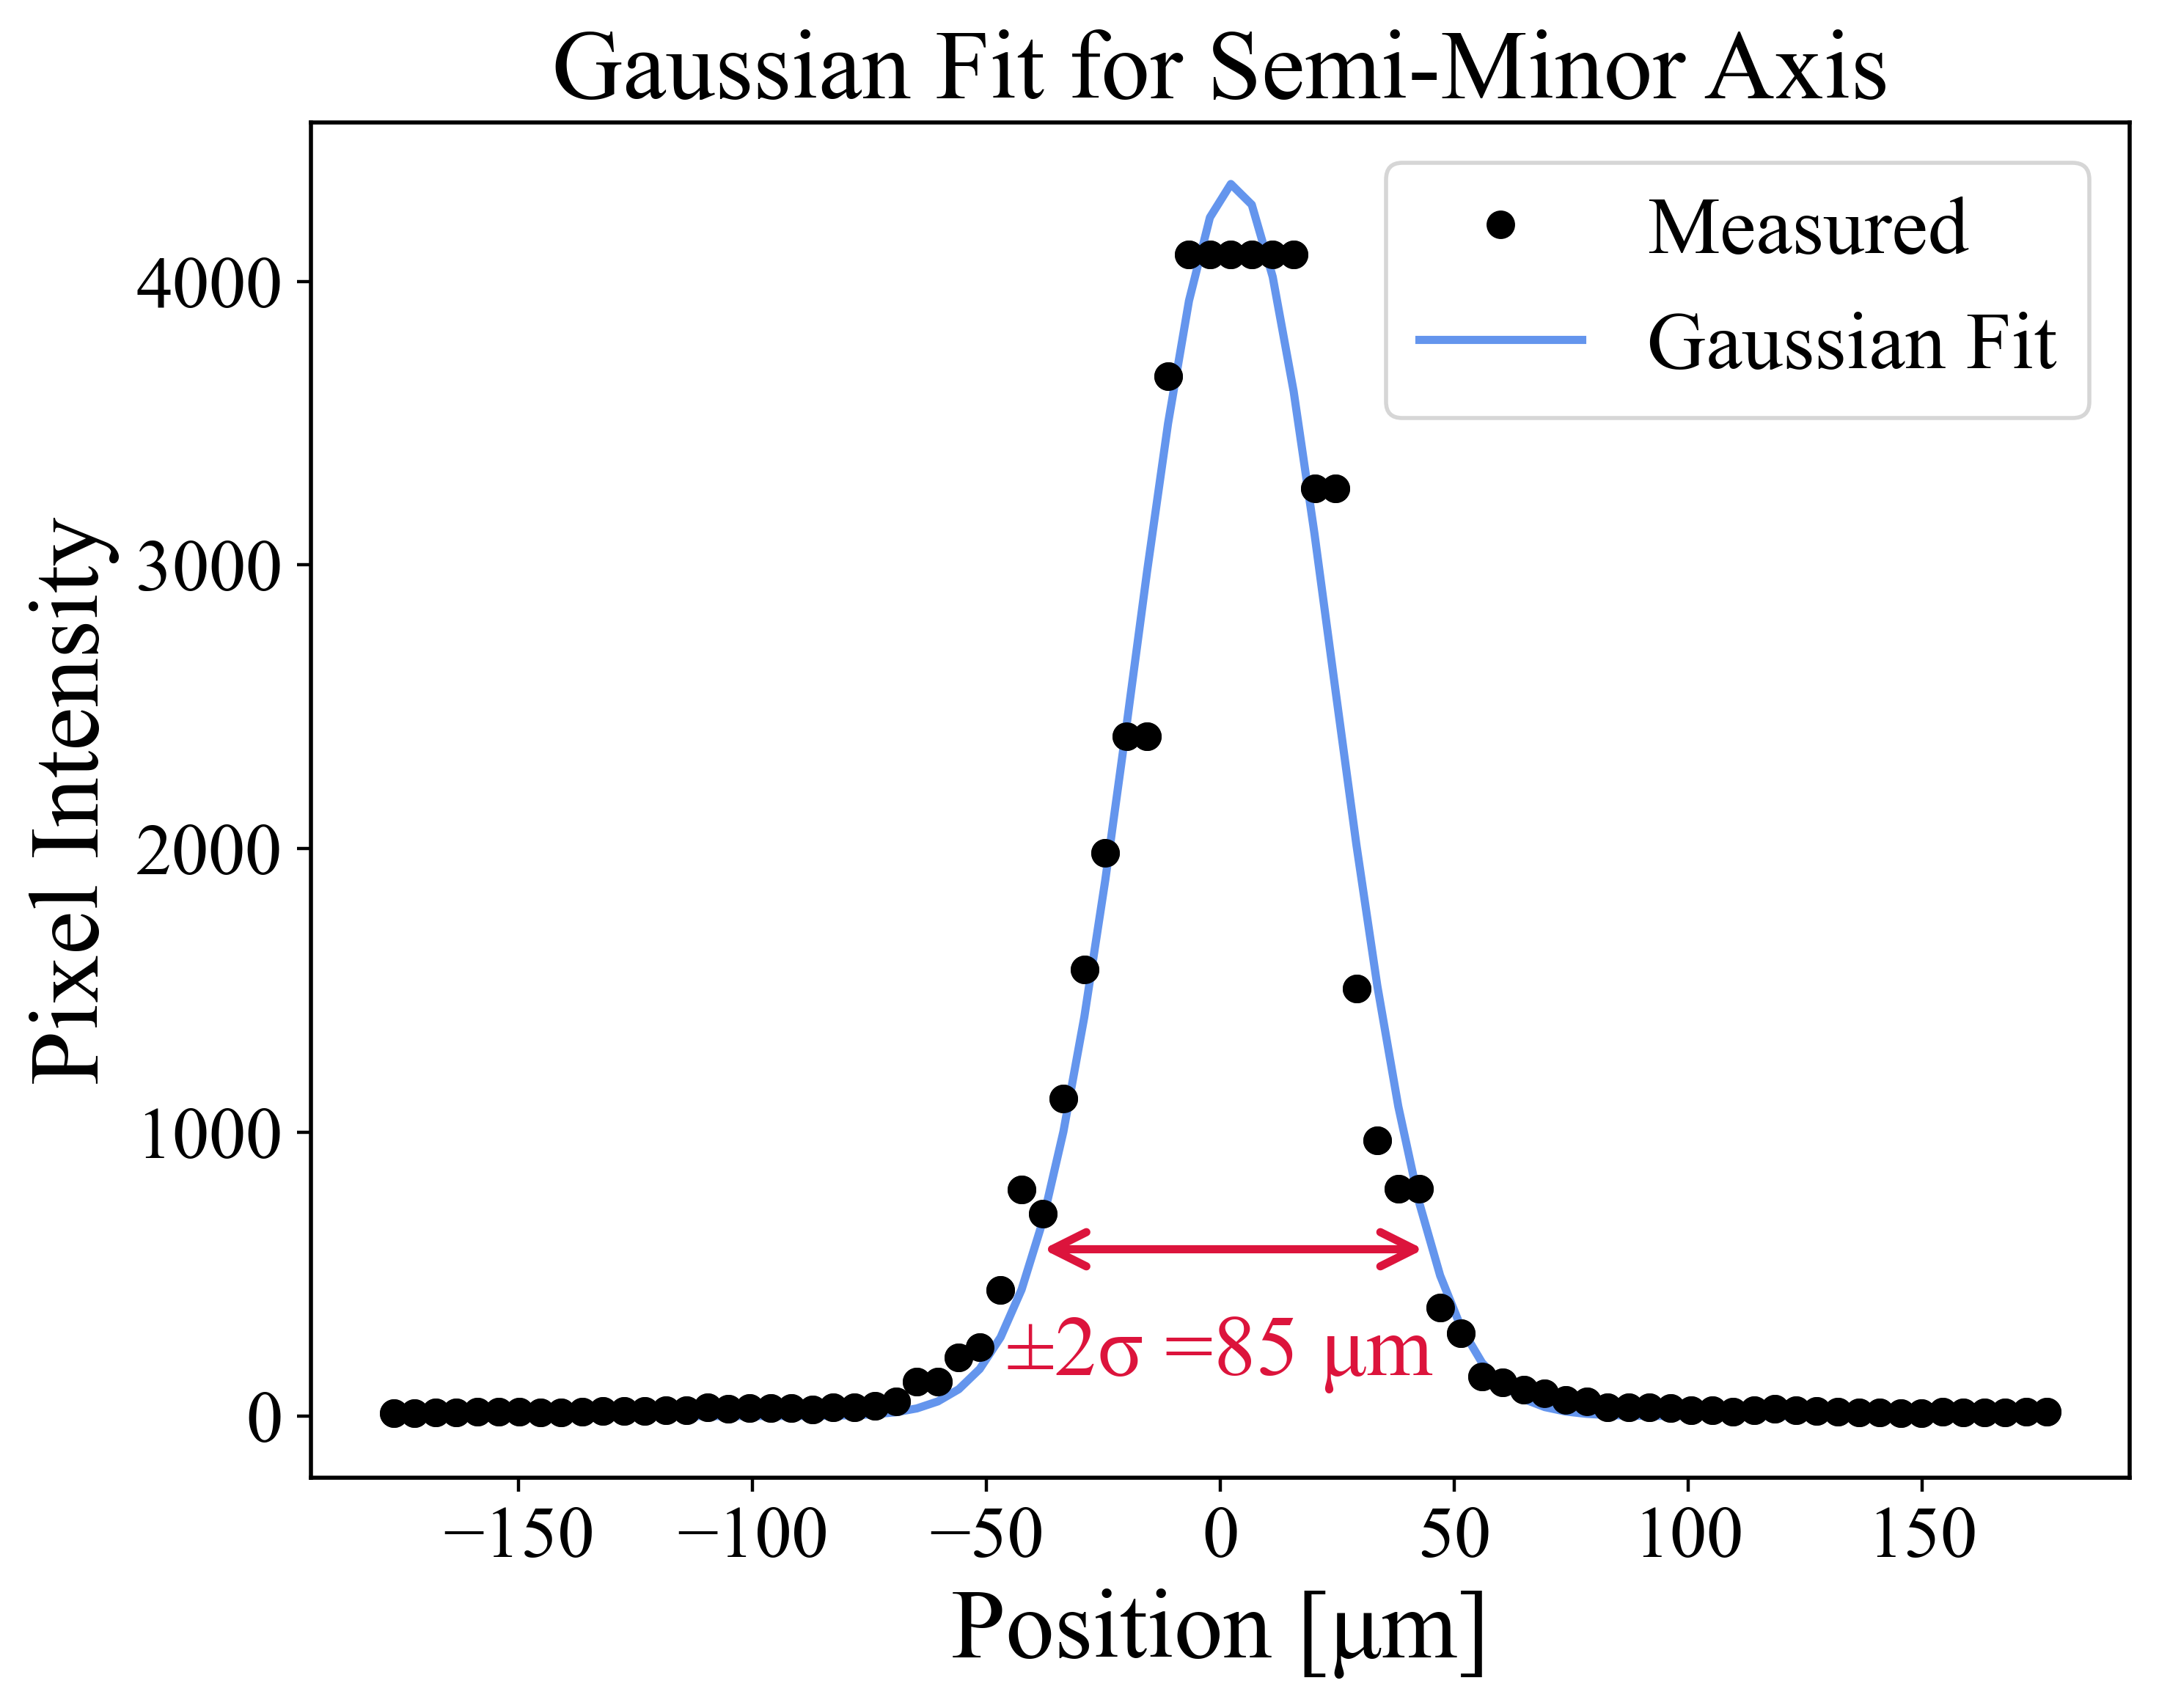

FWHM of the Gaussian: 49.94


In [7]:
fit_gaussian(semiminor_x, semiminor_y, title="Gaussian Fit for Semi-Minor Axis", savepath='./')

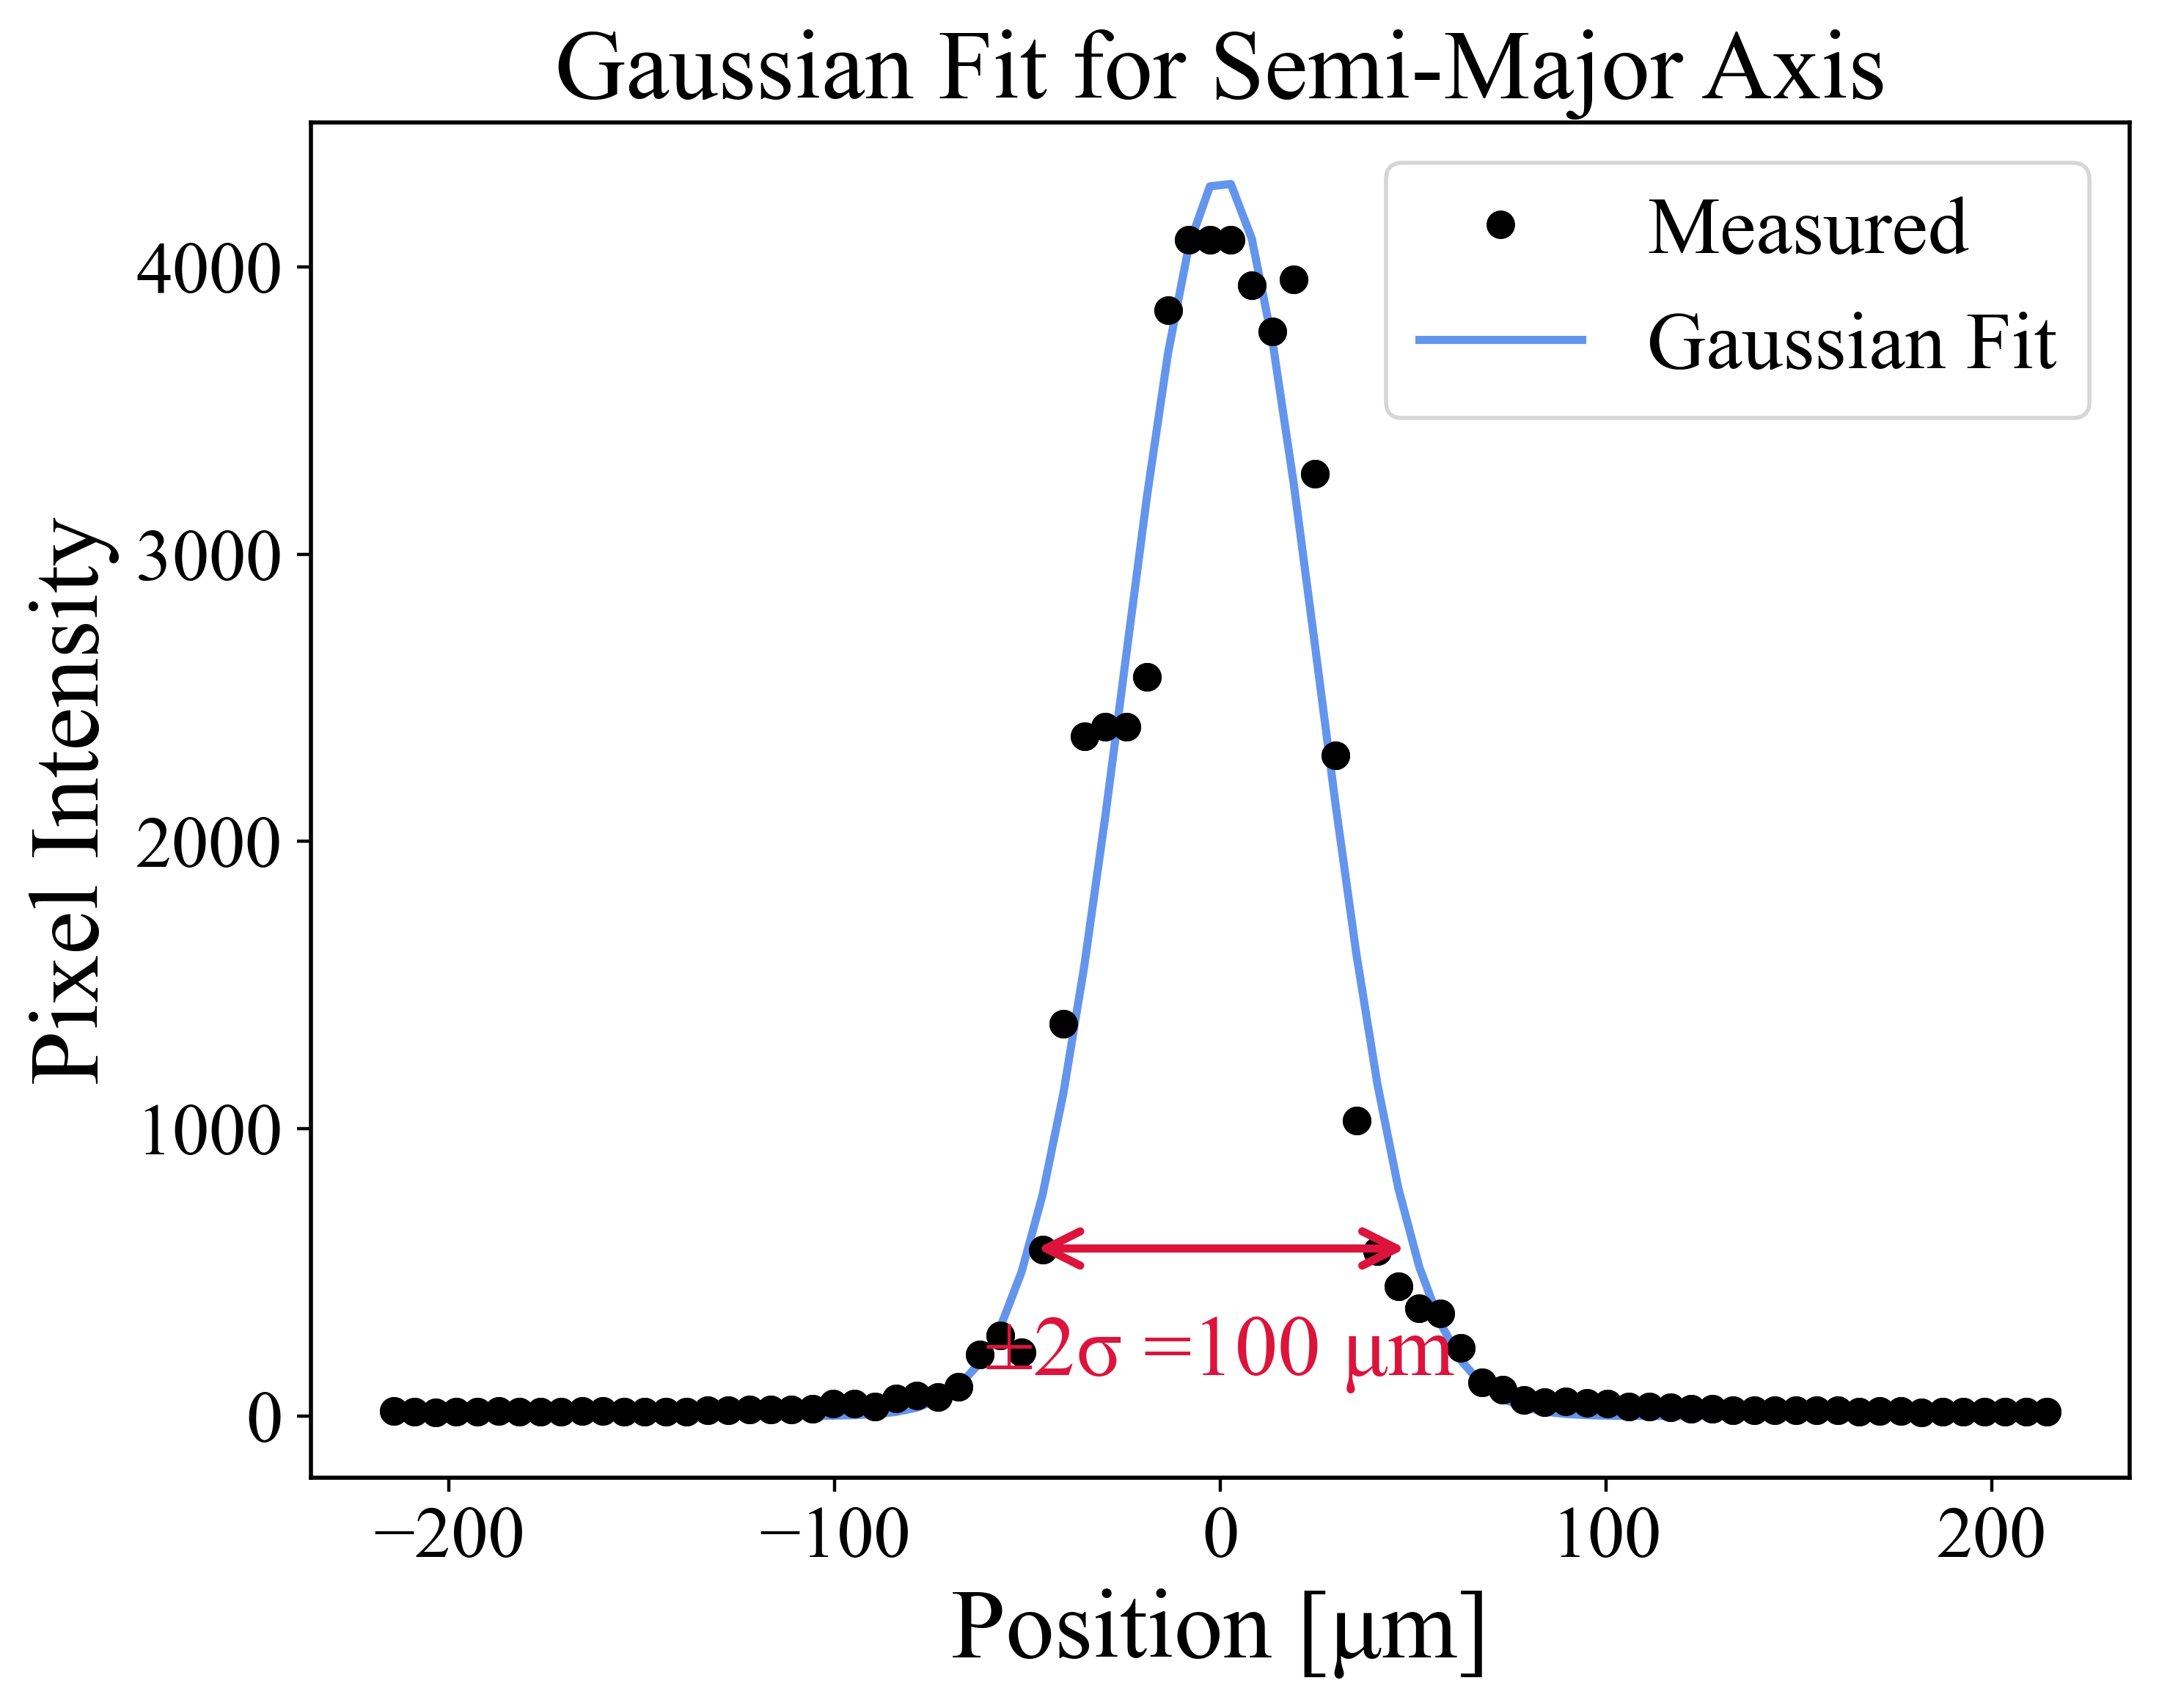

FWHM of the Gaussian: 58.78


In [8]:
fit_gaussian(semimajor_x, semimajor_y, title="Gaussian Fit for Semi-Major Axis", savepath='./')